Do this in the beginning:  
```  
$ THEANO_FLAGS='mode=FAST_RUN,device=gpu,floatX=float32,lib.cnmem=0.85' jupyter notebook  
```   
(no `$` sign, that's just the prompt); run this to make sure the theano code runs on the GPU.  

cf. [Convolutional Neural Network (LeNet)](http://deeplearning.net/tutorial/lenet.html)

In [1]:
%matplotlib inline

In [2]:
import theano
from theano import tensor as T
from theano.tensor.nnet import conv2d

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)


In [3]:
from theano.tensor.signal import pool

# MNIST Data

cf. Found here http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz or https://www-labs.iro.umontreal.ca/~lisa/deep/data/mnist/?C=M;O=A

In [4]:
import os, sys
import gzip
import six.moves.cPickle as pickle 

In [5]:
import numpy
import numpy as np

In [6]:
# find where `mnist.pkl.gz` is on your own computer 
f=gzip.open("../Data/mnist.pkl.gz",'rb')
try:
    train_set,valid_set,test_set = pickle.load(f,encoding='latin1')
except:
    train_set,valid_set,test_set = pickle.load(f)
f.close()

In [7]:
train_set_x,train_set_y=train_set
valid_set_x,valid_set_y=valid_set
test_set_x,test_set_y=test_set
train_set_x = train_set_x.astype(theano.config.floatX)
train_set_y = train_set_y.astype(theano.config.floatX)
valid_set_x = valid_set_x.astype(theano.config.floatX)
valid_set_y = valid_set_y.astype(theano.config.floatX)
test_set_x = test_set_x.astype(theano.config.floatX)
test_set_y = test_set_y.astype(theano.config.floatX)
print(train_set_x.shape,train_set_y.shape) # observe the value for (m,d), number of training examples x number of features
print(valid_set_x.shape,valid_set_y.shape)
print(test_set_x.shape,test_set_y.shape)

((50000, 784), (50000,))
((10000, 784), (10000,))
((10000, 784), (10000,))


In [8]:
# this is for reshaping the MNIST data into something for convolution neural networks
train_set_x = train_set_x.reshape((train_set_x.shape[0],1,28,28))
valid_set_x = valid_set_x.reshape((valid_set_x.shape[0],1,28,28))
test_set_x = test_set_x.reshape((test_set_x.shape[0],1,28,28))
print(train_set_x.shape)
print(valid_set_x.shape)
print(test_set_x.shape)

(50000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)


In [9]:
print(train_set_y.min())
print(train_set_y.max())
print(valid_set_y.min())
print(valid_set_y.max())
print(test_set_y.min())
print(test_set_y.max())


0.0
9.0
0.0
9.0
0.0
9.0


Turn this into a so-called "one-hot vector representation."  

Recall that whereas the original labels (in the variable y) were 0,1, ..., 9 for 10 different (single) digits, for the purpose of training a neural network, we need to recode these labels as vectors containing only values 0 or 1.  

In [10]:
K=10  
m_train = train_set_y.shape[0]
m_valid = valid_set_y.shape[0]
m_test  = test_set_y.shape[0]
y_train = [np.zeros(K) for row in train_set_y] # list of m_train numpy arrays of size dims. (10,)
y_valid = [np.zeros(K) for row in valid_set_y] # list of m_valid numpy arrays of size dims. (10,)
y_test = [np.zeros(K) for row in test_set_y] # list of m_test numpy arrays of size dims. (10,)
for i in range(m_train):
    y_train[i][ int(train_set_y[i]) ] = 1.
for i in range(m_valid):
    y_valid[i][ int(valid_set_y[i]) ] = 1.
for i in range(m_test):
    y_test[i][ int(test_set_y[i]) ] = 1.
y_train = np.array(y_train).astype(theano.config.floatX)
y_valid = np.array(y_valid).astype(theano.config.floatX)
y_test = np.array(y_test).astype(theano.config.floatX)   
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)
(10000, 10)


In [11]:
print(y_train.min())
print(y_train.max())
print(y_valid.min())
print(y_valid.max())
print(y_test.min())
print(y_test.max())

0.0
1.0
0.0
1.0
0.0
1.0


# Convolution operator $*$ and related filter (stencil) $c$ example

In [12]:
import numpy
import numpy as np

In [13]:
rng = np.random.RandomState(23455)

In [9]:
X = T.tensor4(name='X')

c_sizedims = (2,3,9,9) # (C_l,C_lm1,W_1,W_2) = (C_l,C_{l-1},W_1,W_2) 
# (number of feature maps at layer l, number of feature maps at lyaer l-1, filter height, filter width)

c_bound = np.sqrt(3*9*9)
c = theano.shared( np.asarray( rng.uniform(
                                        low=-1.0/c_bound,
                                        high=1.0/c_bound, 
                                        size=c_sizedims),dtype=X.dtype),name='c')

b_sizedim = (2,) # C_l=2
b = theano.shared( np.asarray( 
                    rng.uniform(low=-.5, high=.5, size=b_sizedim), dtype=X.dtype), name='b')

In [56]:
c_shape_temp=theano.function([],c.shape)
print(c_shape_temp())

[2 3 9 9]


In [10]:
# build symbolic expression that computes the convolution of input with filters in c 
conv_out = conv2d(X,c)

In [11]:
# dimshuffle('x',0) -> make a row out of a 1d vector (d to 1xd)
y = T.nnet.sigmoid(conv_out + b.dimshuffle('x',0,'x','x'))

In [15]:
b_shape_temp=theano.function( [],b.dimshuffle('x',0,'x','x').shape ) 
print( b_shape_temp()) # (1,2,1,1) or (1,d,1,1)

[1 2 1 1]


In [16]:
# create theano function to compute filtered images 
f = theano.function([X],y)

Let's have a little bit of fun with this:  

In [13]:
import pylab
from PIL import Image

In [14]:
# open example image of dimensions 639x516, HxW  
img = Image.open(open('../Data/3wolfmoon.jpg'))

In [15]:
print(img.size)  # WxH
print(np.asarray(img).max())
print(np.asarray(img).min())

(516, 639)
255
0


In [16]:
# dimensions are (height,width,channel)
img_np=np.asarray(img,dtype=theano.config.floatX)/256.
print(img_np.shape)
print(img_np.max())
print(img_np.min())

(639, 516, 3)
0.996094
0.0


In [17]:
# put image in 4D tensor of shape (1,3,height,width)
img_ = img_np.transpose(2,0,1).reshape(1,3,639,516)


In [18]:
filtered_img = f(img_)

NameError: name 'img_' is not defined

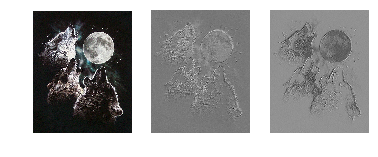

In [27]:
# plot original image and first and second components of output
pylab.subplot(1, 3, 1); pylab.axis('off'); pylab.imshow(img)
pylab.gray();
# recall that the convOp output (filtered image) is actually a "minibatch",
# of size 1 here, so we take index 0 in the first dimension:
pylab.subplot(1, 3, 2); pylab.axis('off'); pylab.imshow(filtered_img[0, 0, :, :])
pylab.subplot(1, 3, 3); pylab.axis('off'); pylab.imshow(filtered_img[0, 1, :, :])
pylab.show()

In [32]:
print(type(img_))
print(img_.shape)
print(img_.max())
print(img_.min())
print(type(filtered_img))
print(filtered_img.shape)
print(filtered_img.max())
print(filtered_img.min())

<type 'numpy.ndarray'>
(1, 3, 639, 516)
0.996094
0.0
<type 'numpy.ndarray'>
(1, 2, 631, 508)
0.661069
0.30252


Empirically, we seen that the image "shrank" in size dimensions.  We can infer that this convolution operation doesn't assume anything about the boundary conditions, and so the filter (stencil), requiring a, in this case, 9x9 "block" or 9x9 values, will only, near the boundaries, output values for the "inside" cells/grid points.  

# MaxPooling

In [33]:
input = T.dtensor4('input')
maxpool_shape=(2,2)
pool_out = pool.pool_2d(input, maxpool_shape, ignore_border=True)
f = theano.function([input],pool_out)

In [34]:
invals=np.random.RandomState(1).rand(3,2,5,5)
print(invals.shape)

(3, 2, 5, 5)


In [35]:
f(invals).shape

(3, 2, 2, 2)

In [36]:
pool_out_false = pool.pool_2d(input,maxpool_shape,ignore_border=False)
f_false = theano.function([input],pool_out_false)

In [37]:
f_false(invals).shape

(3, 2, 3, 3)

In [40]:
invals2 = np.random.RandomState(1).rand(3,2,256,64)
print(f(invals2).shape)
print(f_false(invals2).shape)
invals3 = np.random.RandomState(1).rand(3,2,257,65)
print(f(invals3).shape)
print(f_false(invals3).shape)

(3, 2, 128, 32)
(3, 2, 128, 32)
(3, 2, 128, 32)
(3, 2, 129, 33)


In [41]:
maxpool_shape2=(4,4)
pool_out2 = pool.pool_2d(input, maxpool_shape2, ignore_border=True)
f2 = theano.function([input],pool_out2)
print(f2(invals2).shape)

(3, 2, 64, 16)


In [44]:
C_ls_test = (4,6)
W_ls_test = (640,510)
C_ls_test+W_ls_test

(4, 6, 640, 510)

In [47]:
type(C_ls_test) is type( (0,))

True

In [48]:
len(C_ls_test)

2

In [55]:
np.stack( (np.array(C_ls_test), np.array(W_ls_test)),axis=1)

array([[  4, 640],
       [  6, 510]])

## Convolution axon test

In [14]:
sys.path.append( "../ML/")

In [15]:
import CNN
from CNN import Axon_CNN

In [16]:
c_sizedims = (2,3,9,9) # (C_l,C_lm1,W_1,W_2) = (C_l,C_{l-1},W_1,W_2) 
c_bound = np.sqrt(3*9*9)
c = theano.shared( np.asarray( rng.uniform(
                                        low=-1.0/c_bound,
                                        high=1.0/c_bound, 
                                        size=c_sizedims),dtype=theano.config.floatX),name='c')

b_sizedim = (2,) # C_l=2
b = theano.shared( np.asarray( 
                    rng.uniform(low=-.5, high=.5, size=b_sizedim), dtype=theano.config.floatX), name='b')

In [17]:
Conv_axon_test = Axon_CNN(0,(3,2),(9,9),Pl=None,c=c,b=b,activation=None)

In [18]:
Conv_axon_test.connect_through()

Elemwise{add,no_inplace}.0

In [19]:
f_Conv_axon_test = theano.function([Conv_axon_test.alm1], Conv_axon_test.al)

In [20]:
filtered_img_Conv_axon_test = f_Conv_axon_test(img_)

NameError: name 'img_' is not defined

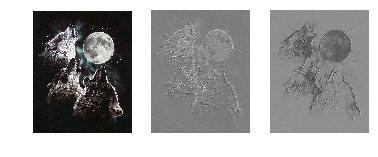

In [25]:
# plot original image and first and second components of output
pylab.subplot(1, 3, 1); pylab.axis('off'); pylab.imshow(img)
pylab.gray();
# recall that the convOp output (filtered image) is actually a "minibatch",
# of size 1 here, so we take index 0 in the first dimension:
pylab.subplot(1, 3, 2); pylab.axis('off'); pylab.imshow(filtered_img_Conv_axon_test[0, 0, :, :])
pylab.subplot(1, 3, 3); pylab.axis('off'); pylab.imshow(filtered_img_Conv_axon_test[0, 1, :, :])
pylab.show()

In [26]:
print(type(img_))
print(img_.shape)
print(img_.max())
print(img_.min())
print(type(filtered_img_Conv_axon_test))
print(filtered_img_Conv_axon_test.shape)
print(filtered_img_Conv_axon_test.max())
print(filtered_img_Conv_axon_test.min())

<type 'numpy.ndarray'>
(1, 3, 639, 516)
0.996094
0.0
<type 'numpy.ndarray'>
(1, 2, 631, 508)
0.668061
-0.835329


In [25]:
"""
# for troubleshooting
l=0
C_ls=(3,2)
W_ls=(9,9)
C_lm1, C_l = C_ls
rng = np.random.RandomState(1234)
fan_in = C_lm1 * np.prod( W_ls)
fan_out = C_l * np.prod(W_ls) // np.prod((2,2))
filter_size = (C_l,C_lm1) + W_ls
"""

In [23]:
"""
# for troubleshooting
c_values = np.asarray( rng.uniform( low=-np.sqrt(6. / ( fan_in + fan_out )), 
                                   high=np.sqrt(6. / ( fan_in + fan_out )), size=filter_size  ), 
dtype=theano.config.floatX )
print(type(c_values))
print(c_values.shape)
"""

<type 'numpy.ndarray'>
(2, 3, 9, 9)


In [29]:
#c = theano.shared(c_values, name="c"+str(l), dtype=theano.config.floatX, borrow=True) get a type error
#c = theano.shared(c_values, name="c"+str(l), borrow=True) get a type error

In [30]:
#help(theano.shared)

## CNN Feedforward test for Convolution Neural Networks  

In [27]:
# sanity check
CNNFF_test = CNN.Feedforward(3,('C','C','D'),
                             [{"C_ls":(1,20) ,"Wl":(5,5),"Pl":(2,2),"Ll":(28,28)},
                             {"C_ls":(20,50),"Wl":(5,5),"Pl":(2,2),"Ll":(12,12)},
                             (50*4*4,500)],
                             psi_L=T.tanh )

In [26]:
# sanity check
#Axon3al = theano.function([], CNNFF_test.Axons[-1].al)
print( type( CNNFF_test.Axons[-1].al ) )

<class 'theano.tensor.var.TensorVariable'>


In [16]:
L=4
CorD=('C','C','D','D')
"""
dims_data_test=[{"feature_maps":(1,20) ,"filter_shape":(5,5),"poolsize":(2,2),"image_size":(28,28)},
               {"feature_maps":(20,50) ,"filter_shape":(5,5),"poolsize":(2,2),"image_size":(12,12)},
               (50*4*4,500),(500,10)] 
               """
dims_data_test=[{"C_ls":(1,20) ,"Wl":(5,5),"Pl":(2,2),"Ll":(28,28)},
               {"C_ls":(20,50) ,"Wl":(5,5),"Pl":(2,2),"Ll":(12,12)},
               (50*4*4,500),(500,10)] 


In [17]:
# sanity check
#CNNFF_test = CNN.Feedforward(L,CorD,dims_data_test,activation_fxn=T.tanh,psi_L=T.nnet.softmax)
CNNFF_test = CNN.Feedforward(L,CorD,dims_data_test,psi_L=T.nnet.softmax)

Notice how 

In [35]:
(dims_data_test[0]["Ll"][0] -dims_data_test[0]["Wl"][0] + 1) // dims_data_test[0]["Pl"][0] == dims_data_test[1]["Ll"][0]

True

## CNN class test as a Deep Neural Network (i.e. Artificial neural network, i.e. no convolution)

In [13]:
L=4
CorD=('D','D','D','D')
dims_data_test=[(784,392), (392,196),(196,98),(98,10)]

In [14]:
CNNFF_test=CNN.Feedforward(L,CorD,dims_data_test,psi_L=T.nnet.softmax)

In [15]:
CNN_test=CNN.CNN(CNNFF_test, X=train_set_x[:20000],y=y_train[:20000])

In [16]:
CNN_test.connect_through(X=train_set_x[:20000])
#CNN_test.connect_through()

Softmax.0

In [17]:
CNN_test.build_J_L2norm_w_reg(0.001)

GpuFromHost.0

In [18]:
CNN_test.build_update(alpha=0.01,beta=0.000001)

In [47]:
CNN_test_train_errs=CNN_test.train_model_full(max_iters=20000)

theano.config.allow_gc =:  True


In [48]:
result = theano.function([],CNN_test._CNN_model._get_outer_layer_())
result = result()

In [49]:
print(type(result))
print(result.shape)


<type 'numpy.ndarray'>
(20000, 10)


In [44]:
train_set_y[:10]

array([ 5.,  0.,  4.,  1.,  9.,  2.,  1.,  3.,  1.,  4.], dtype=float32)

In [50]:
np.argmax(result,axis=1)[:10]

array([3, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [51]:
np.mean( train_set_y[:20000] == np.argmax( result,axis=1) )

0.77685000000000004

# CNN class test for Convolution Neural Networks 

In [29]:
print(train_set_x.shape)

(50000, 1, 28, 28)


In [18]:
CNN_test = CNN.CNN(CNNFF_test,X=train_set_x[:20000],y=y_train[:20000])
#CNN_test = CNN.CNN(CNNFF_test,X=train_set_x,y=y_train)

In [19]:
#CNN_test.connect_through(X=train_set_x) 
CNN_test.connect_through(X=train_set_x[:20000]) 

Softmax.0

In [20]:
CNN_test.build_J_logistic_w_reg(0.001)

GpuFromHost.0

In [21]:
CNN_test.build_update(alpha=0.001, beta=0.000001)  # takes 1 minute, chill

In [25]:
CNN_test_train_errs = CNN_test.train_model_full(max_iters=20000) # 10:09 am for 200 < 1min., 20000 at 10:11 am-11:28 am

theano.config.allow_gc =:  True


In [26]:
result = theano.function([],CNN_test._CNN_model._get_outer_layer_())
result = result()
print(type(result))
print(result.shape)
np.argmax(result,axis=1)[:10]

<type 'numpy.ndarray'>
(20000, 10)


array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [27]:
np.mean( train_set_y[:20000] == np.argmax( result,axis=1) )

0.96389999999999998

In [28]:
# Save parameters like this:
CNN_test.save_parameters("../saved_models/CNN_MNIST.npy")

In [29]:
CNN_test.connect_through(X=valid_set_x)

Softmax.0

In [30]:
CNN_test.y = theano.shared( y_valid.astype(theano.config.floatX),borrow=True)

In [31]:
result_valid = theano.function([],CNN_test._CNN_model._get_outer_layer_())
result_valid = result_valid()
print(type(result_valid))
print(result_valid.shape)
np.argmax(result_valid,axis=1)[:10]

<type 'numpy.ndarray'>
(10000, 10)


array([3, 8, 6, 9, 6, 4, 5, 3, 8, 4])

In [32]:
np.mean( valid_set_y == np.argmax( result_valid,axis=1) )

0.96519999999999995

In [33]:
CNN_test.connect_through(X=test_set_x)

Softmax.0

In [34]:
result_test = theano.function([],CNN_test._CNN_model._get_outer_layer_())
result_test = result_test()
print(type(result_test))
print(result_test.shape)
np.argmax(result_test,axis=1)[:10]

<type 'numpy.ndarray'>
(10000, 10)


array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9])

In [35]:
np.mean( test_set_y == np.argmax( result_test,axis=1) )

0.96299999999999997

In [63]:
#testXsh=theano.shared( np.array( range(1,12+1)).reshape(3,4).astype(theano.config.floatX))
#print(np.array( range(1,12+1)).reshape(3,4))

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]


In [64]:
#testXsumshf = theano.function([],T.sum(testXsh,axis=1))
#testXsumshf_results = testXsumshf()

In [65]:
#testXsumshf_results

array([ 10.,  26.,  42.], dtype=float32)

In [57]:
#12*13/2

78

In [25]:
#testaL4=theano.function([],CNN_test._CNN_model.Axons[3].al)
#testaL4=theano.function([],CNN_test._CNN_model._get_outer_layer_())

In [28]:
#testaL4().shape

(20000, 10)

In [53]:
#range(1,13)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

### Loading back up saved numpy arrays from .save_parameters method in CNN class 

In [39]:
testparam0 = np.load("../saved_models/CNN_MNIST.npy0")
print(type(testparam0))
print(testparam0.shape)

<type 'numpy.ndarray'>
(20, 1, 5, 5)


In [40]:
CNNFF_test_load = CNN.Feedforward(L,CorD,dims_data_test,psi_L=T.nnet.softmax)

In [43]:
params_to_load = []
number_of_params = len( CNNFF_test_load.__get_state__()['params'])
print(number_of_params)
for param_idx in range(number_of_params):
    params_to_load.append( np.load("../saved_models/CNN_MNIST.npy"+str(param_idx)))

8


In [48]:
CNNFF_test_load.__set_state__(*params_to_load)

In [49]:
CNN_test_load = CNN.CNN(CNNFF_test_load,X=valid_set_x,y=y_valid)


In [50]:
CNN_test_load.connect_through(X=valid_set_x)

Softmax.0

In [51]:
result_valid = theano.function([],CNN_test_load._CNN_model._get_outer_layer_())
result_valid = result_valid()
print(type(result_valid))
print(result_valid.shape)
np.argmax(result_valid,axis=1)[:10]

<type 'numpy.ndarray'>
(10000, 10)


array([3, 8, 6, 9, 6, 4, 5, 3, 8, 4])

In [52]:
np.mean( valid_set_y == np.argmax( result_valid,axis=1) )

0.96519999999999995